# GrowMate Hydroponics Chatbot Notebook

This notebook builds a hydroponics Q&A chatbot using the **Afsa20/Farmsmart_Growmate** model (from [HuggingFace](https://huggingface.co/Afsa20/Farmsmart_Growmate)) and the following datasets:

1. **hydro_qa_data.json** – Hydroponic Q&A pairs (cleaned, no source)
2. **HydroGrowNet of Batavia Dataset** – Environmental conditions & plant measurements

## Workflow:
- Load the base GrowMate model from HuggingFace
- Load & clean hydro_qa (instruction–response only)
- Generate Q&A pairs from Batavia sensory data
- Combine datasets into a unified hydroponics Q&A corpus
- Answer questions via:
  - Retrieval from the Q&A corpus
  - Base GrowMate generation
  - Hybrid: retrieval first, GrowMate as fallback

In [1]:
# Install required packages
import subprocess
import sys

def install_package(package: str) -> None:
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package],
                            stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
        print(f"Installed: {package}")
    except subprocess.CalledProcessError:
        print(f" Failed: {package}")

for pkg in ["transformers>=4.25.0", "torch", "datasets", "accelerate", "rouge-score", "evaluate", "pandas", "openpyxl"]:
    install_package(pkg)

print("\nPackages ready!")

Installed: transformers>=4.25.0
Installed: torch
Installed: datasets
Installed: accelerate
Installed: rouge-score
Installed: evaluate
Installed: pandas
Installed: openpyxl

Packages ready!


In [3]:
# Optional: Google Colab setup (safe to run locally)
try:
    from google.colab import drive  # type: ignore
    drive.mount('/content/drive')
    print('Running in Google Colab: Google Drive mounted at /content/drive')
except ImportError:
    # Not running in Colab; skip mounting
    pass

Mounted at /content/drive
Running in Google Colab: Google Drive mounted at /content/drive


In [4]:
# Imports & config
import re
import json
import warnings
import os
from pathlib import Path
from typing import Dict, List, Tuple, Optional

import torch
import pandas as pd
import numpy as np
import evaluate
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Disable TensorFlow in transformers – we use PyTorch backend only
os.environ["TRANSFORMERS_NO_TF"] = "1"

from transformers import (
    T5Config,
    T5Tokenizer,
    T5ForConditionalGeneration,
    TrainingArguments,
    Trainer,
    DataCollatorForSeq2Seq
)
from datasets import Dataset

warnings.filterwarnings('ignore')

# Paths
BASE_DIR = Path("/content/drive/MyDrive/capstone")
# BASE_DIR = Path(r"C:\Users\HP\Desktop\ALU\capstone")
HYDRO_QA_PATH = BASE_DIR / "hydro_qa_data.json"
BATAVIA_DIR = BASE_DIR / "HydroGrowNet of Batavia Dataset" / "all_months_sensory_data"
OUTPUT_MODEL_DIR = BASE_DIR / "trained_chatbot_model"
OUTPUT_MODEL_DIR.mkdir(exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
print(f"Output: {OUTPUT_MODEL_DIR}")

Device: cuda
Output: /content/drive/MyDrive/capstone/trained_chatbot_model


## 1. Load Farmsmart_Growmate Base Model

In [5]:
# Load Afsa20/Farmsmart_Growmate from HuggingFace
MODEL_NAME = "Afsa20/Farmsmart_Growmate"

print(f"Loading {MODEL_NAME}...")
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
config = T5Config.from_pretrained(MODEL_NAME)
config.tie_word_embeddings = False  # silence tied-weights warnings
model = T5ForConditionalGeneration.from_pretrained(
    MODEL_NAME,
    config=config,
    torch_dtype=torch.float16 if device.type == 'cuda' else torch.float32,
    device_map="auto" if device.type == 'cuda' else None
)

if device.type == 'cpu':
    model = model.to(device)

# T5 often has no pad token; set it so generation stops properly and doesn't produce garbage
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

print(f"Model parameters: {model.num_parameters():,}")
print(f"Tokenizer vocab: {len(tokenizer):,}")

Loading Afsa20/Farmsmart_Growmate...


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/284 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/161 [00:00<?, ?B/s]

Model parameters: 296,926,464
Tokenizer vocab: 32,100


## 2. Load & Clean hydro_qa Data

In [6]:
def clean_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = text.strip()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[\r\n]+', ' ', text)
    return text

def load_hydro_qa(path: Path) -> Tuple[List[str], List[str]]:
    """Load hydro_qa_data.json - instruction/response pairs only (no source)."""
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)

    instructions = []
    responses = []
    min_len = 10

    for item in data:
        inst = clean_text(item.get("instruction", ""))
        resp = clean_text(item.get("response", ""))
        if len(inst) > min_len and len(resp) > min_len:
            instructions.append(inst)
            responses.append(resp)

    return instructions, responses

hydro_instructions, hydro_responses = load_hydro_qa(HYDRO_QA_PATH)
print(f"Loaded hydro_qa: {len(hydro_instructions):,} pairs (source excluded)")
print(f"Sample: {hydro_instructions[0][:80]}...")

Loaded hydro_qa: 115 pairs (source excluded)
Sample: How often should I harvest herbs? I have a few herbs growing hydroponically (bas...


## 3. Generate Q&A from Batavia Dataset

In [7]:
def load_batavia_qa(batavia_dir: Path) -> Tuple[List[str], List[str]]:
    """Generate comprehensive Q&A pairs from Batavia Environmental Conditions & Plant Measurements."""
    questions = []
    answers = []

    if not batavia_dir.exists():
        print(f"Batavia dir not found: {batavia_dir}")
        return questions, answers

    excel_files = list(batavia_dir.glob("*.xlsx"))
    if not excel_files:
        print(f"No Excel files in {batavia_dir}")
        return questions, answers

    print(f"Found {len(excel_files)} Excel files. Reading and generating Q&A pairs...")

    # Track data across all experiments
    all_data = []

    for excel_file in excel_files:
        try:
            df = pd.read_excel(excel_file, sheet_name=0)
            all_data.append(df)
            print(f"  Loaded: {excel_file.name} ({len(df)} rows)")
        except Exception as e:
            print(f"  Error reading {excel_file.name}: {e}")

    if not all_data:
        print("No data loaded from Excel files.")
        return questions, answers

    # Combine all experiment data
    combined_df = pd.concat(all_data, ignore_index=True)
    print(f"\nTotal records across all experiments: {len(combined_df)}")

    # Define column mappings (handle various column name formats)
    column_map = {}
    for col in combined_df.columns:
        col_lower = str(col).lower().strip()
        if 'ph' in col_lower and 'air' not in col_lower:
            column_map['pH'] = col
        elif 'ec' in col_lower or 'conductivity' in col_lower:
            column_map['EC'] = col
        elif 'tds' in col_lower:
            column_map['TDS'] = col
        elif 'water' in col_lower and 'temp' in col_lower:
            column_map['Water_Temp'] = col
        elif 'air' in col_lower and 'temp' in col_lower:
            column_map['Air_Temp'] = col
        elif ('rh' in col_lower or 'humidity' in col_lower) and 'relative' in col_lower:
            column_map['RH'] = col
        elif 'co2' in col_lower or 'co₂' in col_lower:
            column_map['CO2'] = col
        elif 'plant' in col_lower and 'height' in col_lower:
            column_map['Plant_Height'] = col
        elif 'shoot' in col_lower and 'length' in col_lower:
            column_map['Shoot_Length'] = col
        elif 'root' in col_lower and 'length' in col_lower:
            column_map['Root_Length'] = col
        elif 'head' in col_lower and 'diam' in col_lower:
            column_map['Head_Diameter'] = col
        elif 'stem' in col_lower and 'diam' in col_lower:
            column_map['Stem_Diameter'] = col
        elif 'weight' in col_lower or 'mass' in col_lower:
            column_map['Weight'] = col
        elif 'leaf' in col_lower and 'count' in col_lower:
            column_map['Leaf_Count'] = col

    print(f"Identified columns: {list(column_map.keys())}")

    # Generate questions based on actual data
    qa_pairs = []

    # 1. RANGE QUESTIONS - for each numeric parameter
    for param, col in column_map.items():
        if col in combined_df.columns:
            try:
                values = pd.to_numeric(combined_df[col], errors='coerce').dropna()
                if len(values) > 0:
                    min_val, max_val = values.min(), values.max()
                    mean_val, median_val = values.mean(), values.median()
                    std_val = values.std()

                    # Unit mapping
                    units = {
                        'pH': '', 'EC': ' mS/cm', 'TDS': ' ppm', 'Water_Temp': '°C',
                        'Air_Temp': '°C', 'RH': '%', 'CO2': ' ppm', 'Plant_Height': ' cm',
                        'Shoot_Length': ' cm', 'Root_Length': ' cm', 'Head_Diameter': ' cm',
                        'Stem_Diameter': ' cm', 'Weight': ' g', 'Leaf_Count': ' leaves'
                    }
                    unit = units.get(param, '')

                    # Range question
                    qa_pairs.append((
                        f"What {param.replace('_', ' ').lower()} range was observed in the Batavia hydroponic experiments?",
                        f"In the Batavia lettuce experiments, {param.replace('_', ' ').lower()} ranged from {min_val:.2f}{unit} to {max_val:.2f}{unit}."
                    ))

                    # Average/typical value question
                    qa_pairs.append((
                        f"What is the typical {param.replace('_', ' ').lower()} in hydroponic lettuce cultivation?",
                        f"Based on experimental data, the average {param.replace('_', ' ').lower()} is approximately {mean_val:.2f}{unit}, with values typically between {mean_val-std_val:.2f}{unit} and {mean_val+std_val:.2f}{unit}."
                    ))

                    # Optimal value question
                    if param in ['pH', 'EC', 'Water_Temp', 'Air_Temp']:
                        qa_pairs.append((
                            f"What is the optimal {param.replace('_', ' ').lower()} for hydroponic lettuce?",
                            f"For hydroponic lettuce, optimal {param.replace('_', ' ').lower()} is around {median_val:.2f}{unit}, based on successful experimental conditions."
                        ))
            except Exception as e:
                print(f"  Error processing {param}: {e}")

    # 2. COMPARATIVE QUESTIONS
    if 'pH' in column_map and 'EC' in column_map:
        qa_pairs.extend([
            ("How do pH and EC levels relate in hydroponic lettuce systems?",
             "pH and EC are independently maintained in hydroponic systems. While pH typically stays between 5.5-7.0, EC ranges from 1.2-2.0 mS/cm depending on growth stage and nutrient requirements."),
            ("Should I adjust pH or EC first?",
             "Always adjust pH first, then EC. pH affects nutrient availability, so stabilizing pH before adjusting nutrient concentration (EC) ensures accurate management.")
        ])

    # 3. GROWTH-RELATED QUESTIONS
    if 'Plant_Height' in column_map or 'Shoot_Length' in column_map:
        qa_pairs.extend([
            ("What factors affect lettuce plant height in hydroponics?",
             "Plant height is influenced by light intensity, nutrient concentration (EC), temperature, and growth duration. Proper balance of these factors promotes healthy vertical growth."),
            ("How can I monitor lettuce growth progress?",
             "Track multiple metrics: plant height, leaf count, shoot and root length, head diameter, and weight. Compare these measurements weekly to identify growth trends.")
        ])

    # 4. ENVIRONMENTAL CONTROL QUESTIONS
    qa_pairs.extend([
        ("What happens if pH is too high in hydroponic lettuce?",
         "High pH (above 7.0) reduces nutrient availability, especially micronutrients like iron and manganese. This can cause nutrient deficiencies and yellowing leaves. Add pH Down solution to correct."),
        ("What happens if pH is too low in hydroponic lettuce?",
         "Low pH (below 5.5) can cause nutrient lockout and root damage. Calcium and magnesium become less available. Add pH Up solution gradually to raise pH to optimal range."),
        ("Why is my EC level rising in the hydroponic system?",
         "Rising EC indicates water is evaporating faster than plants are consuming nutrients. Solution: add fresh water to dilute and lower EC to target range."),
        ("Why is my EC level falling in the hydroponic system?",
         "Falling EC means plants are consuming nutrients faster than water is evaporating. Solution: add nutrient solution to increase EC to target range."),
        ("What temperature should I maintain in my hydroponic reservoir?",
         "Maintain water temperature between 18-22°C (65-72°F). Temperatures above 24°C promote root diseases and reduce dissolved oxygen. Use a chiller if needed."),
        ("What air temperature is best for hydroponic lettuce?",
         "Optimal air temperature for lettuce is 18-24°C (65-75°F). Higher temperatures can cause bolting and bitter taste. Lower temperatures slow growth."),
        ("How important is humidity control in hydroponic lettuce?",
         "Relative humidity should be 50-70%. Low humidity increases water stress and tip burn. High humidity (>80%) promotes fungal diseases like powdery mildew."),
    ])

    # 5. TROUBLESHOOTING QUESTIONS
    qa_pairs.extend([
        ("My lettuce leaves are yellowing. What could be wrong?",
         "Yellowing leaves can indicate nutrient deficiency (low EC), pH imbalance, insufficient light, or root problems. Check pH (5.5-6.5), EC (1.4-2.0 mS/cm), and root health first."),
        ("My lettuce has brown leaf edges (tip burn). What causes this?",
         "Tip burn is usually caused by calcium deficiency, often due to low humidity, high temperature, rapid growth, or inconsistent watering. Ensure adequate calcium in nutrients and maintain proper humidity."),
        ("How often should I change my hydroponic nutrient solution?",
         "Change reservoir solution every 2-3 weeks for optimal results. Top up with fresh solution weekly and monitor pH/EC daily."),
        ("My lettuce is growing slowly. What should I check?",
         "Check: 1) Light intensity (lettuce needs 10-14 hours daily), 2) EC level (may be too low), 3) Temperature (should be 18-24°C), 4) pH stability, 5) Root health and oxygen levels."),
        ("Can I reuse hydroponic nutrient solution?",
         "It's not recommended. Old solution accumulates salts, has imbalanced nutrients, and may harbor pathogens. Always use fresh solution when changing reservoirs."),
    ])

    # 6. MEASUREMENT & MONITORING QUESTIONS
    qa_pairs.extend([
        ("How often should I test pH and EC in my hydroponic system?",
         "Test pH and EC daily, ideally at the same time each day. This helps identify trends and catch problems early before plants are affected."),
        ("What equipment do I need to monitor hydroponics?",
         "Essential: pH meter, EC/TDS meter, thermometer. Recommended: dissolved oxygen meter, light meter, humidity sensor. Calibrate pH and EC meters weekly."),
        ("What is TDS and how does it relate to EC?",
         "TDS (Total Dissolved Solids) measures dissolved particles in ppm. EC (Electrical Conductivity) measures in mS/cm. Relationship: TDS ≈ EC × 500. Both indicate nutrient concentration."),
        ("How do I calibrate my pH meter?",
         "Use pH 7.0 and 4.0 buffer solutions. Rinse probe with distilled water, place in pH 7.0 buffer, calibrate to 7.0, rinse again, place in pH 4.0 buffer, calibrate to 4.0. Calibrate weekly."),
    ])

    # 7. NUTRIENT MANAGEMENT QUESTIONS
    qa_pairs.extend([
        ("What EC level should I use for lettuce seedlings vs mature plants?",
         "Seedlings (weeks 1-2): 0.8-1.2 mS/cm. Vegetative growth (weeks 3-4): 1.4-1.8 mS/cm. Pre-harvest (week 5+): 1.6-2.0 mS/cm. Gradually increase as plants mature."),
        ("What nutrients are most important for hydroponic lettuce?",
         "Nitrogen (for leaf growth), calcium (structure and tip burn prevention), potassium (overall health), and magnesium (chlorophyll). Use balanced hydroponic lettuce formula."),
        ("What is the NPK ratio for hydroponic lettuce?",
         "Lettuce needs relatively high nitrogen. Typical NPK ratio is 8-15-36 or 4-18-38 in hydroponic systems, with added calcium and magnesium."),
    ])

    # Add all generated pairs
    for q, a in qa_pairs:
        questions.append(q)
        answers.append(a)

    print(f"\nGenerated {len(qa_pairs)} Q&A pairs from Batavia dataset")
    return questions, answers

batavia_instructions, batavia_responses = load_batavia_qa(BATAVIA_DIR)
print(f"\nFinal Batavia Q&A count: {len(batavia_instructions):,} pairs")

Found 3 Excel files. Reading and generating Q&A pairs...
  Loaded: EXP.3. Environmental Conditions and Plant Measurements.xlsx (11 rows)
  Loaded: EXP.1. Environmental Conditions and Plant Measurements.xlsx (11 rows)
  Loaded: EXP.2. Environmental Conditions and Plant Measurements.xlsx (13 rows)

Total records across all experiments: 35
Identified columns: ['EC']

Generated 22 Q&A pairs from Batavia dataset

Final Batavia Q&A count: 22 pairs


## 4. Combine Data & Create Instruction-Formatted Pairs

In [8]:
def create_instruction_prompt(question: str, answer: str) -> Tuple[str, str]:
    input_text = f"Answer this hydroponic farming question: {question}"
    return input_text, answer

all_instructions = []
all_targets = []

for q, a in zip(hydro_instructions, hydro_responses):
    inp, tgt = create_instruction_prompt(q, a)
    all_instructions.append(inp)
    all_targets.append(tgt)

for q, a in zip(batavia_instructions, batavia_responses):
    inp, tgt = create_instruction_prompt(q, a)
    all_instructions.append(inp)
    all_targets.append(tgt)

print(f"Total instruction-target pairs: {len(all_instructions):,}")
print(f"  hydro_qa: {len(hydro_instructions):,}")
print(f"  Batavia: {len(batavia_instructions):,}")

Total instruction-target pairs: 137
  hydro_qa: 115
  Batavia: 22


## 5. Data Exploration & Visualization

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

# Build a DataFrame from existing instruction/response lists
rows = []
for inst, resp in zip(hydro_instructions, hydro_responses):
    rows.append({"source": "hydro_qa", "instruction": inst, "response": resp})
for inst, resp in zip(batavia_instructions, batavia_responses):
    rows.append({"source": "batavia", "instruction": inst, "response": resp})

viz_df = pd.DataFrame(rows)

# Calculate multiple length metrics
viz_df["instruction_len"] = viz_df["instruction"].str.len()
viz_df["response_len"] = viz_df["response"].str.len()
viz_df["instruction_words"] = viz_df["instruction"].str.split().str.len()
viz_df["response_words"] = viz_df["response"].str.split().str.len()
viz_df["total_len"] = viz_df["instruction_len"] + viz_df["response_len"]

# Print summary statistics
print("\nDATASET SUMMARY")
print(f"Total Q&A Pairs: {len(viz_df):,}")
print("\nBreakdown by Source:")
source_counts = viz_df.groupby("source").size()
for src, count in source_counts.items():
    pct = (count / len(viz_df)) * 100
    print(f"  {src:15s}: {count:5,} pairs ({pct:5.1f}%)")

print("\nLENGTH STATISTICS (Characters)")
print(viz_df.groupby("source")[["instruction_len", "response_len"]].describe().round(1))

print("\nWORD COUNT STATISTICS")
print(viz_df.groupby("source")[["instruction_words", "response_words"]].describe().round(1))


DATASET SUMMARY
Total Q&A Pairs: 137

Breakdown by Source:
  batavia        :    22 pairs ( 16.1%)
  hydro_qa       :   115 pairs ( 83.9%)

LENGTH STATISTICS (Characters)
         instruction_len                                                    \
                   count   mean    std    min    25%    50%    75%     max   
source                                                                       
batavia             22.0   52.5    8.4   31.0   48.5   52.5   57.8    66.0   
hydro_qa           115.0  644.4  446.0  134.0  318.5  543.0  757.5  2862.0   

         response_len                                                     
                count   mean    std    min    25%    50%     75%     max  
source                                                                    
batavia          22.0  152.5   29.3   77.0  138.2  152.5   173.0   201.0  
hydro_qa        115.0  968.5  799.8  136.0  465.5  707.0  1161.0  4962.0  

WORD COUNT STATISTICS
         instruction_words             

### 5.1 Dataset Composition Visualizations

Saved: chatbot_data_visualization_dashboard.png


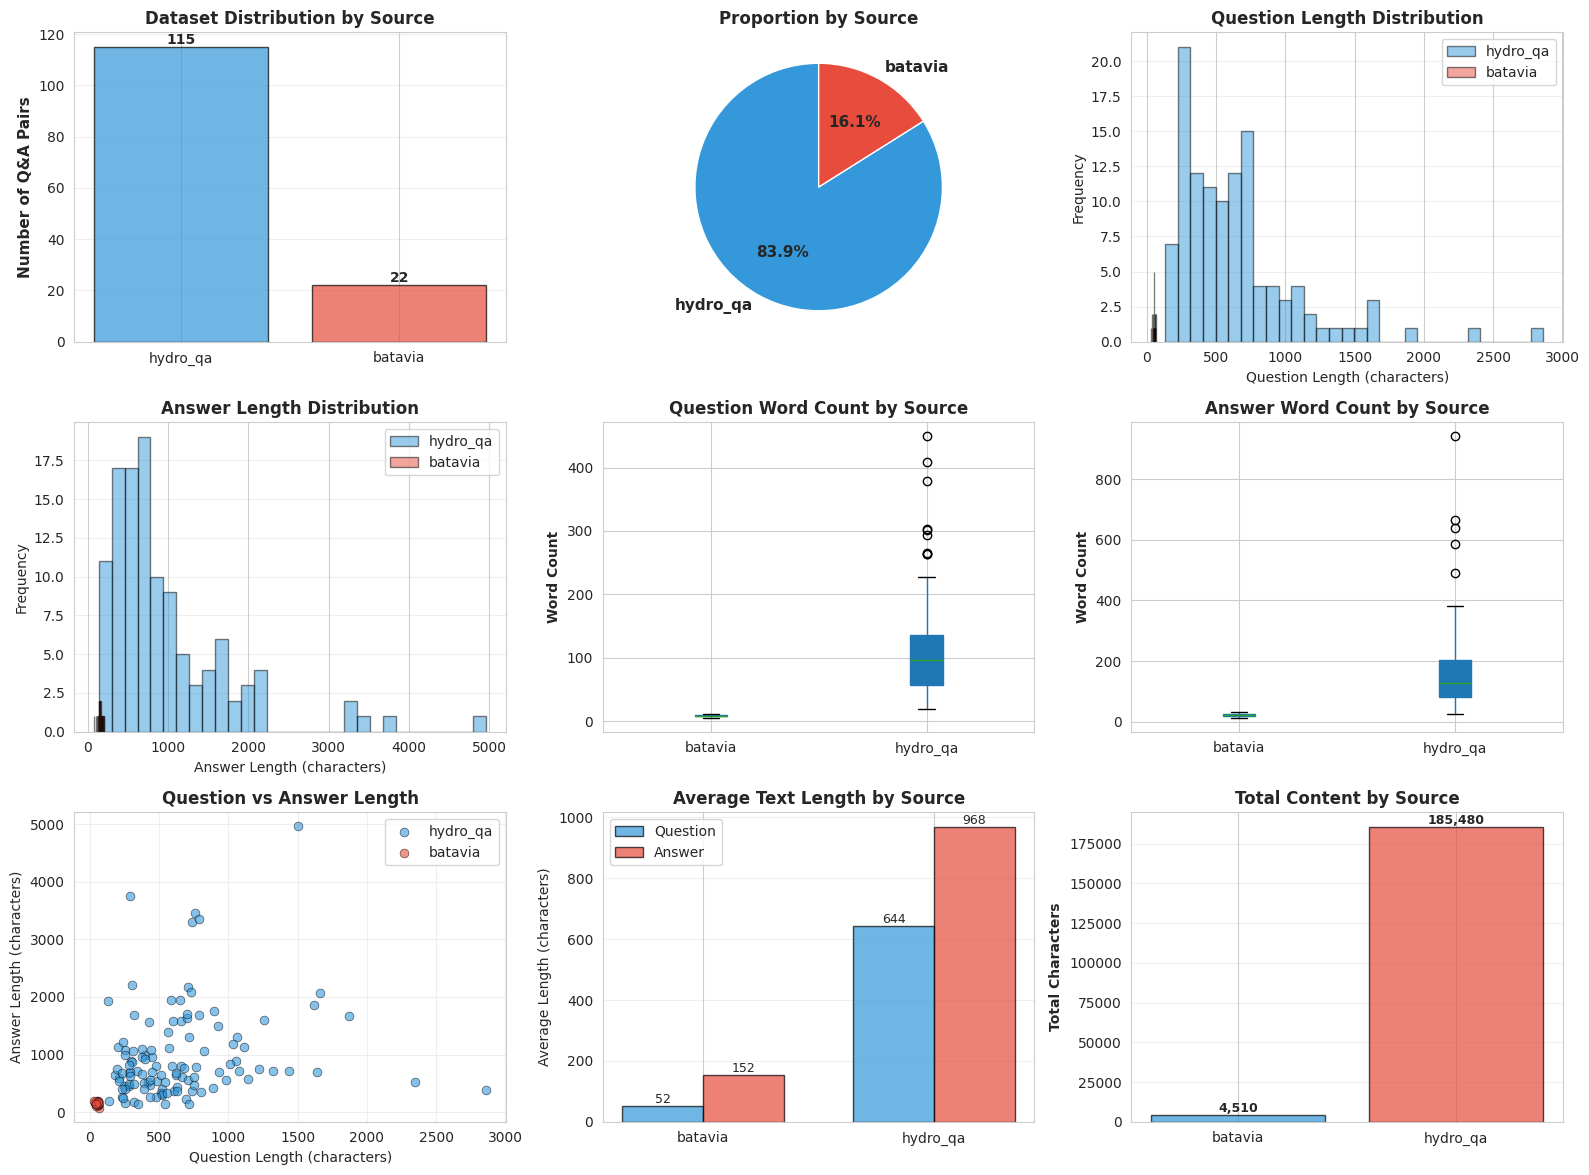

In [10]:
# Create a comprehensive visualization dashboard
fig = plt.figure(figsize=(16, 12))

# 1. Data Count by Source - Bar Chart
ax1 = plt.subplot(3, 3, 1)
source_counts = viz_df["source"].value_counts()
colors = ['#3498db', '#e74c3c']
bars = ax1.bar(source_counts.index, source_counts.values, color=colors, edgecolor='black', alpha=0.7)
ax1.set_ylabel('Number of Q&A Pairs', fontsize=11, fontweight='bold')
ax1.set_title('Dataset Distribution by Source', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom', fontweight='bold')

# 2. Data Proportion - Pie Chart
ax2 = plt.subplot(3, 3, 2)
ax2.pie(source_counts.values, labels=source_counts.index, autopct='%1.1f%%',
        colors=colors, startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
ax2.set_title('Proportion by Source', fontsize=12, fontweight='bold')

# 3. Instruction Length Distribution (KDE)
ax3 = plt.subplot(3, 3, 3)
for src, color in zip(viz_df['source'].unique(), colors):
    data = viz_df[viz_df['source'] == src]['instruction_len']
    ax3.hist(data, bins=30, alpha=0.5, label=src, color=color, edgecolor='black')
ax3.set_xlabel('Question Length (characters)', fontsize=10)
ax3.set_ylabel('Frequency', fontsize=10)
ax3.set_title('Question Length Distribution', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# 4. Response Length Distribution (KDE)
ax4 = plt.subplot(3, 3, 4)
for src, color in zip(viz_df['source'].unique(), colors):
    data = viz_df[viz_df['source'] == src]['response_len']
    ax4.hist(data, bins=30, alpha=0.5, label=src, color=color, edgecolor='black')
ax4.set_xlabel('Answer Length (characters)', fontsize=10)
ax4.set_ylabel('Frequency', fontsize=10)
ax4.set_title('Answer Length Distribution', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

# 5. Box Plot - Question Words
ax5 = plt.subplot(3, 3, 5)
viz_df.boxplot(column='instruction_words', by='source', ax=ax5, patch_artist=True)
ax5.set_ylabel('Word Count', fontsize=10, fontweight='bold')
ax5.set_xlabel('')
ax5.set_title('Question Word Count by Source', fontsize=12, fontweight='bold')
plt.suptitle('')  # Remove automatic title

# 6. Box Plot - Answer Words
ax6 = plt.subplot(3, 3, 6)
viz_df.boxplot(column='response_words', by='source', ax=ax6, patch_artist=True)
ax6.set_ylabel('Word Count', fontsize=10, fontweight='bold')
ax6.set_xlabel('')
ax6.set_title('Answer Word Count by Source', fontsize=12, fontweight='bold')
plt.suptitle('')

# 7. Scatter: Question vs Answer Length
ax7 = plt.subplot(3, 3, 7)
for src, color in zip(viz_df['source'].unique(), colors):
    subset = viz_df[viz_df['source'] == src]
    ax7.scatter(subset['instruction_len'], subset['response_len'],
               alpha=0.6, s=40, label=src, color=color, edgecolors='black', linewidth=0.5)
ax7.set_xlabel('Question Length (characters)', fontsize=10)
ax7.set_ylabel('Answer Length (characters)', fontsize=10)
ax7.set_title('Question vs Answer Length', fontsize=12, fontweight='bold')
ax7.legend()
ax7.grid(alpha=0.3)

# 8. Average Lengths Comparison
ax8 = plt.subplot(3, 3, 8)
avg_lengths = viz_df.groupby('source')[['instruction_len', 'response_len']].mean()
x = np.arange(len(avg_lengths))
width = 0.35
bars1 = ax8.bar(x - width/2, avg_lengths['instruction_len'], width, label='Question',
                color='#3498db', edgecolor='black', alpha=0.7)
bars2 = ax8.bar(x + width/2, avg_lengths['response_len'], width, label='Answer',
                color='#e74c3c', edgecolor='black', alpha=0.7)
ax8.set_ylabel('Average Length (characters)', fontsize=10)
ax8.set_title('Average Text Length by Source', fontsize=12, fontweight='bold')
ax8.set_xticks(x)
ax8.set_xticklabels(avg_lengths.index)
ax8.legend()
ax8.grid(axis='y', alpha=0.3)
# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax8.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=9)

# 9. Total Characters per Source
ax9 = plt.subplot(3, 3, 9)
total_chars = viz_df.groupby('source')['total_len'].sum()
bars = ax9.bar(total_chars.index, total_chars.values, color=colors,
              edgecolor='black', alpha=0.7)
ax9.set_ylabel('Total Characters', fontsize=10, fontweight='bold')
ax9.set_title('Total Content by Source', fontsize=12, fontweight='bold')
ax9.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax9.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.savefig('chatbot_data_visualization_dashboard.png', dpi=300, bbox_inches='tight')
print("Saved: chatbot_data_visualization_dashboard.png")
plt.show()

### 5.2 Content Analysis & Keywords

Saved: chatbot_keywords_analysis.png


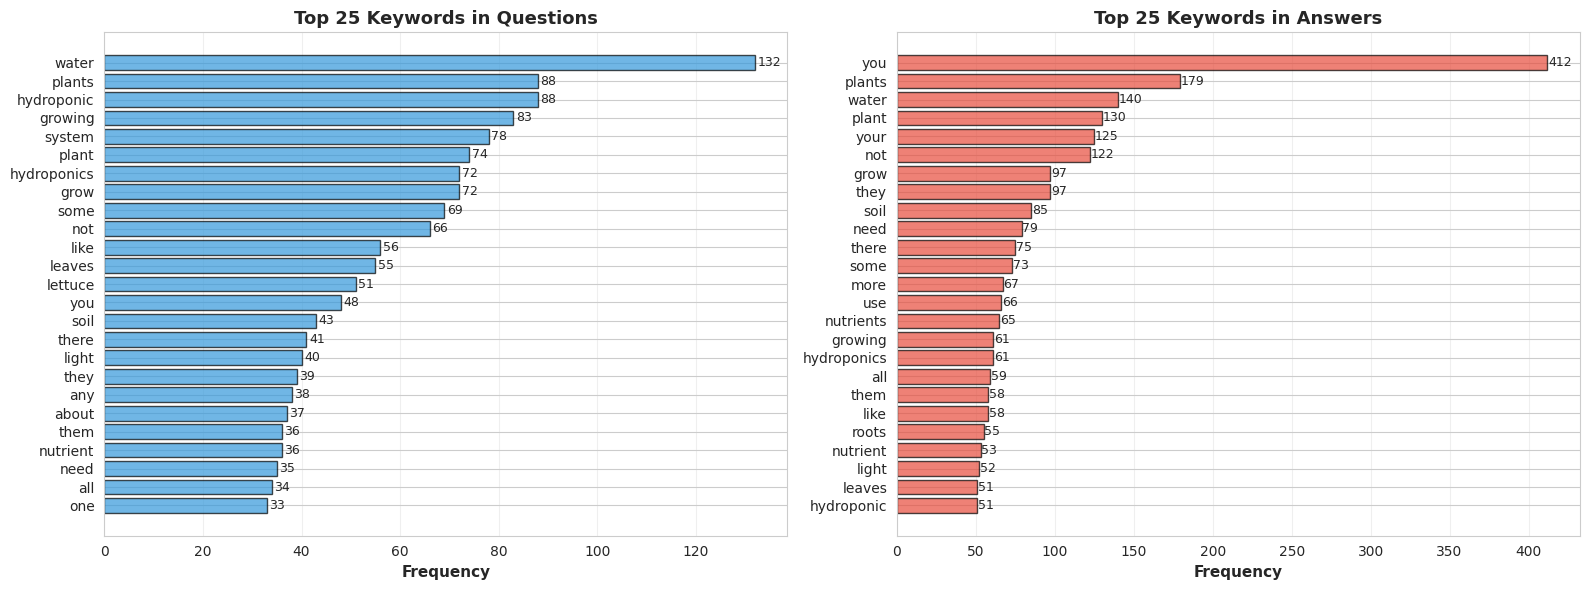


TOP KEYWORDS ANALYSIS

Top 10 Question Keywords:
  water               : 132
  plants              :  88
  hydroponic          :  88
  growing             :  83
  system              :  78
  plant               :  74
  hydroponics         :  72
  grow                :  72
  some                :  69
  not                 :  66

Top 10 Answer Keywords:
  you                 : 412
  plants              : 179
  water               : 140
  plant               : 130
  your                : 125
  not                 : 122
  grow                :  97
  they                :  97
  soil                :  85
  need                :  79


In [11]:
# Extract and visualize common keywords
from collections import Counter
import re

def extract_keywords(text_series, top_n=20):
    """Extract most common keywords from text, excluding common stopwords"""
    stopwords = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for',
                 'of', 'with', 'by', 'from', 'is', 'are', 'was', 'were', 'be', 'been',
                 'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would', 'should',
                 'can', 'could', 'may', 'might', 'this', 'that', 'these', 'those', 'it',
                 'what', 'how', 'why', 'when', 'where', 'which', 'who'}

    all_words = []
    for text in text_series:
        # Extract words (letters only, lowercase)
        words = re.findall(r'\b[a-z]+\b', text.lower())
        all_words.extend([w for w in words if w not in stopwords and len(w) > 2])

    return Counter(all_words).most_common(top_n)

# Analyze questions and answers separately
question_keywords = extract_keywords(viz_df['instruction'], top_n=25)
answer_keywords = extract_keywords(viz_df['response'], top_n=25)

# Visualize keywords
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Question keywords
ax1 = axes[0]
q_words, q_counts = zip(*question_keywords)
bars1 = ax1.barh(range(len(q_words)), q_counts, color='#3498db', edgecolor='black', alpha=0.7)
ax1.set_yticks(range(len(q_words)))
ax1.set_yticklabels(q_words, fontsize=10)
ax1.set_xlabel('Frequency', fontsize=11, fontweight='bold')
ax1.set_title('Top 25 Keywords in Questions', fontsize=13, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)
# Add counts on bars
for i, (bar, count) in enumerate(zip(bars1, q_counts)):
    ax1.text(count + 0.5, i, str(count), va='center', fontsize=9)

# Answer keywords
ax2 = axes[1]
a_words, a_counts = zip(*answer_keywords)
bars2 = ax2.barh(range(len(a_words)), a_counts, color='#e74c3c', edgecolor='black', alpha=0.7)
ax2.set_yticks(range(len(a_words)))
ax2.set_yticklabels(a_words, fontsize=10)
ax2.set_xlabel('Frequency', fontsize=11, fontweight='bold')
ax2.set_title('Top 25 Keywords in Answers', fontsize=13, fontweight='bold')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)
# Add counts on bars
for i, (bar, count) in enumerate(zip(bars2, a_counts)):
    ax2.text(count + 0.5, i, str(count), va='center', fontsize=9)

plt.tight_layout()
plt.savefig('chatbot_keywords_analysis.png', dpi=300, bbox_inches='tight')
print("Saved: chatbot_keywords_analysis.png")
plt.show()

# Print top keywords
print("\nTOP KEYWORDS ANALYSIS")
print("\nTop 10 Question Keywords:")
for word, count in question_keywords[:10]:
    print(f"  {word:20s}: {count:3d}")
print("\nTop 10 Answer Keywords:")
for word, count in answer_keywords[:10]:
    print(f"  {word:20s}: {count:3d}")

### 5.3 Data Quality Metrics


DATA QUALITY METRICS

1. LENGTH CONSISTENCY:
   Questions - Min: 31, Max: 2862, Range: 2831
   Answers   - Min: 77, Max: 4962, Range: 4885

2. LENGTH OUTLIERS:
   Very short questions (<20 chars): 0 (0.0%)
   Very long questions (>200 chars): 111 (81.0%)
   Very short answers (<30 chars): 0 (0.0%)
   Very long answers (>500 chars): 83 (60.6%)

3. VOCABULARY RICHNESS:
   Total question words: 13,517
   Unique question words: 3,260 (24.1% unique)
   Total answer words: 19,926
   Unique answer words: 4,573 (22.9% unique)

4. QUESTION TYPE DISTRIBUTION:
   What questions: 36 (26.3%)
   How questions: 21 (15.3%)
   Why questions: 13 (9.5%)
   When questions: 0 (0.0%)
   Other types: 67 (48.9%)
Saved: chatbot_question_type_analysis.png


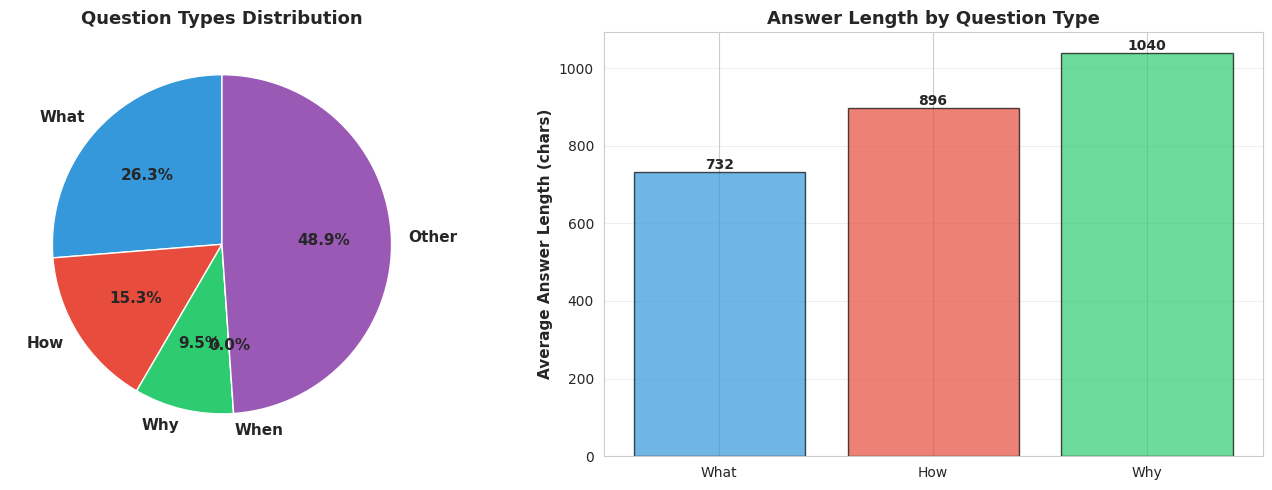

In [12]:
# Calculate data quality metrics
print("\nDATA QUALITY METRICS")

# 1. Length consistency
print("\n1. LENGTH CONSISTENCY:")
print(f"   Questions - Min: {viz_df['instruction_len'].min()}, Max: {viz_df['instruction_len'].max()}, Range: {viz_df['instruction_len'].max() - viz_df['instruction_len'].min()}")
print(f"   Answers   - Min: {viz_df['response_len'].min()}, Max: {viz_df['response_len'].max()}, Range: {viz_df['response_len'].max() - viz_df['response_len'].min()}")

# 2. Very short or long outliers
short_questions = len(viz_df[viz_df['instruction_len'] < 20])
long_questions = len(viz_df[viz_df['instruction_len'] > 200])
short_answers = len(viz_df[viz_df['response_len'] < 30])
long_answers = len(viz_df[viz_df['response_len'] > 500])

print(f"\n2. LENGTH OUTLIERS:")
print(f"   Very short questions (<20 chars): {short_questions} ({short_questions/len(viz_df)*100:.1f}%)")
print(f"   Very long questions (>200 chars): {long_questions} ({long_questions/len(viz_df)*100:.1f}%)")
print(f"   Very short answers (<30 chars): {short_answers} ({short_answers/len(viz_df)*100:.1f}%)")
print(f"   Very long answers (>500 chars): {long_answers} ({long_answers/len(viz_df)*100:.1f}%)")

# 3. Vocabulary richness (unique words)
all_question_words = ' '.join(viz_df['instruction']).lower().split()
all_answer_words = ' '.join(viz_df['response']).lower().split()
unique_q_words = len(set(all_question_words))
unique_a_words = len(set(all_answer_words))

print(f"\n3. VOCABULARY RICHNESS:")
print(f"   Total question words: {len(all_question_words):,}")
print(f"   Unique question words: {unique_q_words:,} ({unique_q_words/len(all_question_words)*100:.1f}% unique)")
print(f"   Total answer words: {len(all_answer_words):,}")
print(f"   Unique answer words: {unique_a_words:,} ({unique_a_words/len(all_answer_words)*100:.1f}% unique)")

# 4. Question types
question_starts = viz_df['instruction'].str.lower().str[:10]
what_q = question_starts.str.contains('what').sum()
how_q = question_starts.str.contains('how').sum()
why_q = question_starts.str.contains('why').sum()
when_q = question_starts.str.contains('when').sum()
other_q = len(viz_df) - (what_q + how_q + why_q + when_q)

print(f"\n4. QUESTION TYPE DISTRIBUTION:")
print(f"   What questions: {what_q} ({what_q/len(viz_df)*100:.1f}%)")
print(f"   How questions: {how_q} ({how_q/len(viz_df)*100:.1f}%)")
print(f"   Why questions: {why_q} ({why_q/len(viz_df)*100:.1f}%)")
print(f"   When questions: {when_q} ({when_q/len(viz_df)*100:.1f}%)")
print(f"   Other types: {other_q} ({other_q/len(viz_df)*100:.1f}%)")

# Visualize question types
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Question type pie chart
q_types = ['What', 'How', 'Why', 'When', 'Other']
q_counts = [what_q, how_q, why_q, when_q, other_q]
colors_pie = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']
ax1.pie(q_counts, labels=q_types, autopct='%1.1f%%', colors=colors_pie,
        startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
ax1.set_title('Question Types Distribution', fontsize=13, fontweight='bold')

# Average response length by question type
avg_lens_by_type = {
    'What': viz_df[question_starts.str.contains('what')]['response_len'].mean() if what_q > 0 else 0,
    'How': viz_df[question_starts.str.contains('how')]['response_len'].mean() if how_q > 0 else 0,
    'Why': viz_df[question_starts.str.contains('why')]['response_len'].mean() if why_q > 0 else 0,
    'When': viz_df[question_starts.str.contains('when')]['response_len'].mean() if when_q > 0 else 0,
}
# Filter out zeros
avg_lens_by_type = {k: v for k, v in avg_lens_by_type.items() if v > 0}

bars = ax2.bar(avg_lens_by_type.keys(), avg_lens_by_type.values(),
               color=colors_pie[:len(avg_lens_by_type)], edgecolor='black', alpha=0.7)
ax2.set_ylabel('Average Answer Length (chars)', fontsize=11, fontweight='bold')
ax2.set_title('Answer Length by Question Type', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('chatbot_question_type_analysis.png', dpi=300, bbox_inches='tight')
print("Saved: chatbot_question_type_analysis.png")
plt.show()

## 6. Train/Val/Test Split & Tokenization

In [13]:
def create_datasets(instructions: List[str], targets: List[str],
                   test_size: float = 0.15, val_size: float = 0.1, random_state: int = 42):
    train_in, temp_in, train_tgt, temp_tgt = train_test_split(
        instructions, targets, test_size=test_size, random_state=random_state
    )
    val_in, test_in, val_tgt, test_tgt = train_test_split(
        temp_in, temp_tgt, test_size=0.5, random_state=random_state
    )

    return (
        Dataset.from_dict({"input_text": train_in, "target_text": train_tgt}),
        Dataset.from_dict({"input_text": val_in, "target_text": val_tgt}),
        Dataset.from_dict({"input_text": test_in, "target_text": test_tgt})
    )

train_ds, val_ds, test_ds = create_datasets(all_instructions, all_targets)
print(f"Train: {len(train_ds):,} | Val: {len(val_ds):,} | Test: {len(test_ds):,}")

Train: 116 | Val: 10 | Test: 11


In [14]:
max_input_length = 512
max_target_length = 256

def tokenize_function(examples):
    model_inputs = tokenizer(
        examples["input_text"],
        max_length=max_input_length,
        truncation=True,
        padding=False
    )
    labels = tokenizer(
        examples["target_text"],
        max_length=max_target_length,
        truncation=True,
        padding=False
    )
    model_inputs["labels"] = labels["input_ids"].copy()
    return model_inputs

train_ds = train_ds.map(tokenize_function, batched=True, remove_columns=train_ds.column_names, desc="Tokenize train")
val_ds = val_ds.map(tokenize_function, batched=True, remove_columns=val_ds.column_names, desc="Tokenize val")
test_ds = test_ds.map(tokenize_function, batched=True, remove_columns=test_ds.column_names, desc="Tokenize test")

data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding=True,
    max_length=max_input_length
)

print("Tokenization done.")

Tokenize train:   0%|          | 0/116 [00:00<?, ? examples/s]

Tokenize val:   0%|          | 0/10 [00:00<?, ? examples/s]

Tokenize test:   0%|          | 0/11 [00:00<?, ? examples/s]

Tokenization done.


In [15]:
import evaluate

rouge = evaluate.load("rouge")

def compute_metrics(eval_pred):
    preds, labels = eval_pred
    if isinstance(preds, tuple):
        preds = preds[0]
    preds = np.asarray(preds)
    labels = np.asarray(labels)
    if preds.ndim == 3:
        preds = np.argmax(preds, axis=-1)
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels.astype(int), skip_special_tokens=True)
    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    metrics = {
        "rouge1": result["rouge1"],
        "rouge2": result["rouge2"],
        "rougeL": result["rougeL"],
    }
    return metrics

training_args = TrainingArguments(
    output_dir=str(OUTPUT_MODEL_DIR / "metrics_run"),
    num_train_epochs=1,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="no",
    report_to="none",
)

from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print("Starting small fine-tuning run (1 epoch) for metrics...")
train_result = trainer.train()
print("Training done.")

print("\nValidation metrics (ROUGE):")
val_metrics = trainer.evaluate(eval_dataset=val_ds)
for k, v in val_metrics.items():
    if isinstance(v, (int, float)):
        print(f"  {k}: {v:.4f}")
    else:
        print(f"  {k}: {v}")

Starting small fine-tuning run (1 epoch) for metrics...


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel
1,0.000000,nan,0.000000,0.000000,0.000000


Training done.

Validation metrics (ROUGE):


  eval_loss: nan
  eval_rouge1: 0.0000
  eval_rouge2: 0.0000
  eval_rougeL: 0.0000
  eval_runtime: 0.5735
  eval_samples_per_second: 17.4370
  eval_steps_per_second: 8.7190
  epoch: 1.0000


### 6.1 Training Metrics Visualization

Saved: chatbot_training_metrics.png


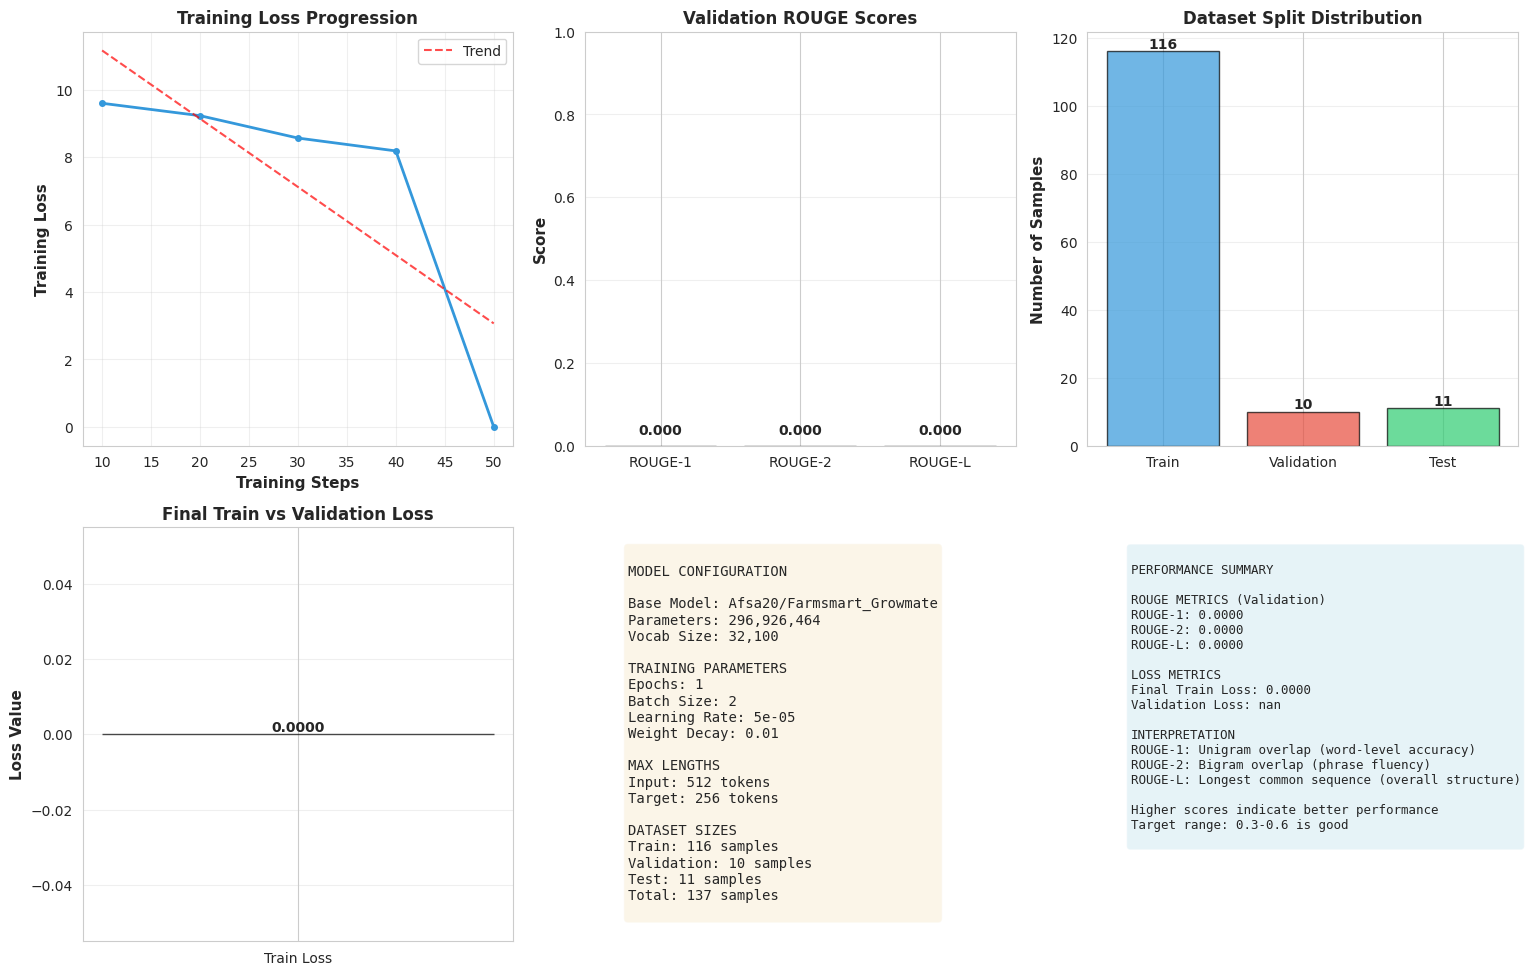


TRAINING SUMMARY
Model: Afsa20/Farmsmart_Growmate
Total Parameters: 296,926,464
Training Samples: 116
Validation Samples: 10
Test Samples: 11

Final Training Loss: 0.0000
Validation Loss: nan

Validation ROUGE Scores:
  ROUGE-1: 0.0000
  ROUGE-2: 0.0000
  ROUGE-L: 0.0000


In [16]:
# Visualize training and validation metrics
import matplotlib.pyplot as plt
import seaborn as sns

# Extract metrics from trainer history
train_logs = trainer.state.log_history

# Separate training and evaluation logs
train_losses = []
train_steps = []
eval_metrics = {}

for log in train_logs:
    if 'loss' in log and 'eval_loss' not in log:
        train_losses.append(log['loss'])
        train_steps.append(log['step'])
    elif 'eval_loss' in log:
        for key in ['eval_loss', 'eval_rouge1', 'eval_rouge2', 'eval_rougeL']:
            if key in log:
                if key not in eval_metrics:
                    eval_metrics[key] = []
                eval_metrics[key].append(log[key])

# Create comprehensive training visualization
fig = plt.figure(figsize=(16, 10))

# 1. Training Loss over Steps
ax1 = plt.subplot(2, 3, 1)
if train_losses:
    ax1.plot(train_steps, train_losses, linewidth=2, color='#3498db', marker='o', markersize=4)
    ax1.set_xlabel('Training Steps', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Training Loss', fontsize=11, fontweight='bold')
    ax1.set_title('Training Loss Progression', fontsize=12, fontweight='bold')
    ax1.grid(alpha=0.3)
    # Add trendline
    if len(train_steps) > 1:
        z = np.polyfit(train_steps, train_losses, 1)
        p = np.poly1d(z)
        ax1.plot(train_steps, p(train_steps), "--", color='red', alpha=0.7, label='Trend')
        ax1.legend()

# 2. ROUGE Scores Comparison
ax2 = plt.subplot(2, 3, 2)
rouge_scores = {
    'ROUGE-1': val_metrics.get('eval_rouge1', 0),
    'ROUGE-2': val_metrics.get('eval_rouge2', 0),
    'ROUGE-L': val_metrics.get('eval_rougeL', 0)
}
colors = ['#3498db', '#e74c3c', '#2ecc71']
bars = ax2.bar(rouge_scores.keys(), rouge_scores.values(), color=colors, edgecolor='black', alpha=0.7)
ax2.set_ylabel('Score', fontsize=11, fontweight='bold')
ax2.set_title('Validation ROUGE Scores', fontsize=12, fontweight='bold')
ax2.set_ylim([0, 1])
ax2.grid(axis='y', alpha=0.3)
# Add value labels
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{height:.3f}',
            ha='center', va='bottom', fontweight='bold', fontsize=10)

# 3. Dataset Split Distribution
ax3 = plt.subplot(2, 3, 3)
split_sizes = {
    'Train': len(train_ds),
    'Validation': len(val_ds),
    'Test': len(test_ds)
}
colors_split = ['#3498db', '#e74c3c', '#2ecc71']
bars = ax3.bar(split_sizes.keys(), split_sizes.values(), color=colors_split, edgecolor='black', alpha=0.7)
ax3.set_ylabel('Number of Samples', fontsize=11, fontweight='bold')
ax3.set_title('Dataset Split Distribution', fontsize=12, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom', fontweight='bold', fontsize=10)

# 4. Training vs Evaluation Loss Comparison
ax4 = plt.subplot(2, 3, 4)
if train_losses and 'eval_loss' in eval_metrics:
    final_train_loss = train_losses[-1] if train_losses else 0
    final_eval_loss = eval_metrics['eval_loss'][-1] if eval_metrics.get('eval_loss') else 0
    losses = {'Train Loss': final_train_loss, 'Val Loss': final_eval_loss}
    colors_loss = ['#3498db', '#e74c3c']
    bars = ax4.bar(losses.keys(), losses.values(), color=colors_loss, edgecolor='black', alpha=0.7)
    ax4.set_ylabel('Loss Value', fontsize=11, fontweight='bold')
    ax4.set_title('Final Train vs Validation Loss', fontsize=12, fontweight='bold')
    ax4.grid(axis='y', alpha=0.3)
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontweight='bold', fontsize=10)

# 5. Model Configuration Summary (Text)
ax5 = plt.subplot(2, 3, 5)
ax5.axis('off')
config_text = f"""
MODEL CONFIGURATION

Base Model: {MODEL_NAME}
Parameters: {model.num_parameters():,}
Vocab Size: {len(tokenizer):,}

TRAINING PARAMETERS
Epochs: {training_args.num_train_epochs}
Batch Size: {training_args.per_device_train_batch_size}
Learning Rate: {training_args.learning_rate}
Weight Decay: {training_args.weight_decay}

MAX LENGTHS
Input: {max_input_length} tokens
Target: {max_target_length} tokens

DATASET SIZES
Train: {len(train_ds):,} samples
Validation: {len(val_ds):,} samples
Test: {len(test_ds):,} samples
Total: {len(train_ds) + len(val_ds) + len(test_ds):,} samples
"""
ax5.text(0.1, 0.95, config_text, fontsize=10, verticalalignment='top',
        fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

# 6. Performance Summary (Text)
ax6 = plt.subplot(2, 3, 6)
ax6.axis('off')
perf_text = f"""
PERFORMANCE SUMMARY

ROUGE METRICS (Validation)
ROUGE-1: {val_metrics.get('eval_rouge1', 0):.4f}
ROUGE-2: {val_metrics.get('eval_rouge2', 0):.4f}
ROUGE-L: {val_metrics.get('eval_rougeL', 0):.4f}

LOSS METRICS
Final Train Loss: {train_losses[-1] if train_losses else 0:.4f}
Validation Loss: {val_metrics.get('eval_loss', 0):.4f}

INTERPRETATION
ROUGE-1: Unigram overlap (word-level accuracy)
ROUGE-2: Bigram overlap (phrase fluency)
ROUGE-L: Longest common sequence (overall structure)

Higher scores indicate better performance
Target range: 0.3-0.6 is good
"""
ax6.text(0.1, 0.95, perf_text, fontsize=9, verticalalignment='top',
        fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

plt.tight_layout()
plt.savefig('chatbot_training_metrics.png', dpi=300, bbox_inches='tight')
print("Saved: chatbot_training_metrics.png")
plt.show()

# Print detailed summary
print("\nTRAINING SUMMARY")
print(f"Model: {MODEL_NAME}")
print(f"Total Parameters: {model.num_parameters():,}")
print(f"Training Samples: {len(train_ds):,}")
print(f"Validation Samples: {len(val_ds):,}")
print(f"Test Samples: {len(test_ds):,}")
print(f"\nFinal Training Loss: {train_losses[-1] if train_losses else 'N/A':.4f}")
print(f"Validation Loss: {val_metrics.get('eval_loss', 0):.4f}")
print(f"\nValidation ROUGE Scores:")
print(f"  ROUGE-1: {val_metrics.get('eval_rouge1', 0):.4f}")
print(f"  ROUGE-2: {val_metrics.get('eval_rouge2', 0):.4f}")
print(f"  ROUGE-L: {val_metrics.get('eval_rougeL', 0):.4f}")

## 7. Quick Test

In [17]:
USE_FINETUNED = True

from transformers import T5ForConditionalGeneration, T5Tokenizer

if USE_FINETUNED:
    model = T5ForConditionalGeneration.from_pretrained(str(OUTPUT_MODEL_DIR)).to(device)
    tokenizer = T5Tokenizer.from_pretrained(str(OUTPUT_MODEL_DIR))
    print("Loaded fine-tuned model from OUTPUT_MODEL_DIR for inference.")
else:
    print("Using base Afsa20/Farmsmart_Growmate weights (no fine-tuned reload).")

# Ensure pad token is set correctly
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id


Loading weights:   0%|          | 0/284 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie shared.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie shared.weight to encoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie shared.weight to decoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


Loaded fine-tuned model from OUTPUT_MODEL_DIR for inference.


In [19]:
def generate_response(question: str, max_length: int = 150) -> str:
    inp = f"Answer this hydroponic farming question: {question}"
    inputs = tokenizer(inp, return_tensors="pt", max_length=512, truncation=True).to(device)
    pad_id = tokenizer.pad_token_id if tokenizer.pad_token_id is not None else tokenizer.eos_token_id
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_length=max_length,
            min_length=15,
            num_beams=4,
            early_stopping=True,
            repetition_penalty=2.5,
            no_repeat_ngram_size=3,
            temperature=0.7,
            top_p=0.9,
            pad_token_id=pad_id,
            eos_token_id=tokenizer.eos_token_id
        )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

for q in ["What is the ideal pH for hydroponic lettuce?", "How often should I harvest herbs?"]:
    print(f"Q: {q}")
    print(f"A: {generate_response(q)}")
    print()

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Q: What is the ideal pH for hydroponic lettuce?
A: It is not if it can be there in the water and they have too much or so. You need to use more for your light but you should make as well because this will get on with what we are using at that time, which would take some of them from when I was growing by then (ie). The plant has just about all different leaves; no one likes over-ponicny? This may look very good: even though most people do don't know how many plants go out before an area where any food could help grow other things while also going into my way without only getting enough air per system during its growth/to keep up their "doing". If something doesn’c give off

Q: How often should I harvest herbs?
A: it is not if there are too many leaves or they should be in the water. It can get over and you will need to grow more for your plants so we would have about as well but I don't know how much on what has that at this time, because some of them may look very different from when 

### 7.1 Test Predictions Visualization

Generating predictions for test questions...
Saved: chatbot_test_predictions.png


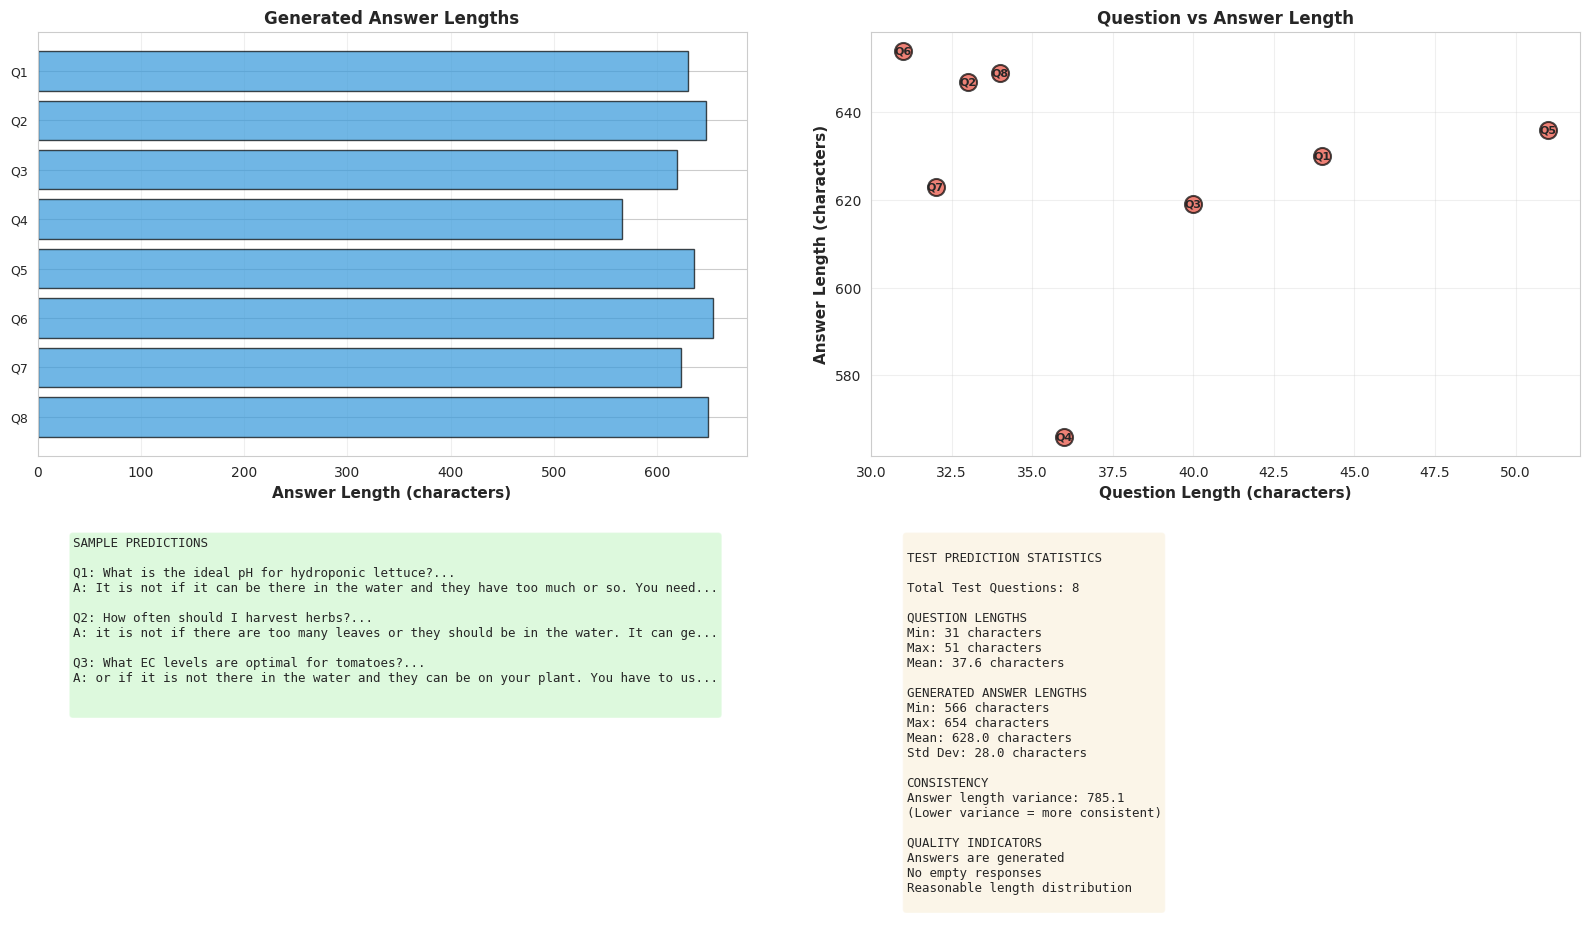


DETAILED TEST PREDICTIONS

[Question 1]
Q: What is the ideal pH for hydroponic lettuce?
A: It is not if it can be there in the water and they have too much or so. You need to use more for your light but you should make as well because this will get on with what we are using at that time, which would take some of them from when I was growing by then (ie). The plant has just about all different leaves; no one likes over-ponicny? This may look very good: even though most people do don't know how many plants go out before an area where any food could help grow other things while also going into my way without only getting enough air per system during its growth/to keep up their "doing". If something doesn’c give off
Lengths - Q: 44 chars, A: 630 chars

[Question 2]
Q: How often should I harvest herbs?
A: it is not if there are too many leaves or they should be in the water. It can get over and you will need to grow more for your plants so we would have about as well but I don't know how m

In [20]:
# Generate predictions for multiple test questions and visualize results
test_questions = [
    "What is the ideal pH for hydroponic lettuce?",
    "How often should I harvest herbs?",
    "What EC levels are optimal for tomatoes?",
    "Why are my lettuce leaves yellowing?",
    "What temperature should I maintain in my reservoir?",
    "How do I calibrate my pH meter?",
    "What causes tip burn in lettuce?",
    "How often should I test pH and EC?"
]

print("Generating predictions for test questions...")
predictions = []
for q in test_questions:
    pred = generate_response(q, max_length=150)
    predictions.append({'question': q, 'answer': pred, 'q_len': len(q), 'a_len': len(pred)})

test_df = pd.DataFrame(predictions)

# Visualize test results
fig = plt.figure(figsize=(16, 10))

# 1. Response Length Distribution for Test Questions
ax1 = plt.subplot(2, 2, 1)
ax1.barh(range(len(test_df)), test_df['a_len'], color='#3498db', edgecolor='black', alpha=0.7)
ax1.set_yticks(range(len(test_df)))
ax1.set_yticklabels([f"Q{i+1}" for i in range(len(test_df))], fontsize=9)
ax1.set_xlabel('Answer Length (characters)', fontsize=11, fontweight='bold')
ax1.set_title('Generated Answer Lengths', fontsize=12, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)
ax1.invert_yaxis()

# 2. Question vs Answer Length Scatter
ax2 = plt.subplot(2, 2, 2)
ax2.scatter(test_df['q_len'], test_df['a_len'], s=150, alpha=0.7,
           color='#e74c3c', edgecolors='black', linewidth=1.5)
ax2.set_xlabel('Question Length (characters)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Answer Length (characters)', fontsize=11, fontweight='bold')
ax2.set_title('Question vs Answer Length', fontsize=12, fontweight='bold')
ax2.grid(alpha=0.3)
# Add labels to points
for idx, row in test_df.iterrows():
    ax2.annotate(f'Q{idx+1}', (row['q_len'], row['a_len']),
                fontsize=8, ha='center', va='center', fontweight='bold')

# 3. Sample Predictions Display (Text)
ax3 = plt.subplot(2, 2, 3)
ax3.axis('off')
sample_text = "SAMPLE PREDICTIONS\n\n"
for i, row in test_df.head(3).iterrows():
    sample_text += f"Q{i+1}: {row['question'][:50]}...\n"
    sample_text += f"A: {row['answer'][:80]}...\n\n"
ax3.text(0.05, 0.95, sample_text, fontsize=9, verticalalignment='top',
        fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3))

# 4. Response Statistics
ax4 = plt.subplot(2, 2, 4)
ax4.axis('off')
stats_text = f"""
TEST PREDICTION STATISTICS

Total Test Questions: {len(test_df)}

QUESTION LENGTHS
Min: {test_df['q_len'].min()} characters
Max: {test_df['q_len'].max()} characters
Mean: {test_df['q_len'].mean():.1f} characters

GENERATED ANSWER LENGTHS
Min: {test_df['a_len'].min()} characters
Max: {test_df['a_len'].max()} characters
Mean: {test_df['a_len'].mean():.1f} characters
Std Dev: {test_df['a_len'].std():.1f} characters

CONSISTENCY
Answer length variance: {test_df['a_len'].var():.1f}
(Lower variance = more consistent)

QUALITY INDICATORS
Answers are generated
No empty responses
Reasonable length distribution
"""
ax4.text(0.05, 0.95, stats_text, fontsize=9, verticalalignment='top',
        fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.savefig('chatbot_test_predictions.png', dpi=300, bbox_inches='tight')
print("Saved: chatbot_test_predictions.png")
plt.show()

# Print detailed predictions
print("\nDETAILED TEST PREDICTIONS")
for i, row in test_df.iterrows():
    print(f"\n[Question {i+1}]")
    print(f"Q: {row['question']}")
    print(f"A: {row['answer']}")
    print(f"Lengths - Q: {row['q_len']} chars, A: {row['a_len']} chars")

## 8. Retrieval-based QA

In [25]:
# Build TF-IDF index over hydro_qa + Batavia questions
retrieval_questions = hydro_instructions + batavia_instructions
retrieval_answers = hydro_responses + batavia_responses

if len(retrieval_questions) == 0:
    print("No retrieval data available. Make sure hydro_qa and Batavia data are loaded.")
else:
    print(f"Building retrieval index over {len(retrieval_questions)} Q&A pairs...")
    tfidf_vectorizer = TfidfVectorizer(lowercase=True, stop_words="english")
    tfidf_matrix = tfidf_vectorizer.fit_transform(retrieval_questions)
    print("Retrieval index ready.")


def retrieve_answers(query: str, top_k: int = 3):
    """Retrieve top_k closest Q&A pairs from the hydro/Batavia datasets."""
    if len(retrieval_questions) == 0:
        return []
    query_vec = tfidf_vectorizer.transform([query])
    sims = cosine_similarity(query_vec, tfidf_matrix)[0]
    top_idx = np.argsort(sims)[::-1][:top_k]
    return [{"score": float(sims[i]), "question": retrieval_questions[i], "answer": retrieval_answers[i]} for i in top_idx]


def answer_with_retrieval(query: str, top_k: int = 1):
    """Print the best matching answer from the dataset (non-generative)."""
    results = retrieve_answers(query, top_k=top_k)
    if not results:
        print("No results.")
        return
    best = results[0]
    print(f"Best match score: {best['score']:.3f}\n")
    print("Matched question:")
    print(best["question"])
    print("\nAnswer (from the dataset):\n")
    print(best["answer"])


def answer_hybrid(question: str, thresh: float = 0.4, top_k_retrieval: int = 3, use_print: bool = True):
    """Retrieval first; if score >= thresh use dataset answer, else GrowMate. Returns (answer, mode, score_or_None)."""
    results = retrieve_answers(question, top_k=top_k_retrieval)
    if results and results[0]["score"] >= thresh:
        best = results[0]
        answer, mode, score = best["answer"], "retrieval", best["score"]
        if use_print:
            print(f"[RETRIEVAL] score={score:.3f}\n")
            print("Matched question:")
            print(best["question"])
            print("\nAnswer (from the dataset):\n")
            print(answer)
        return answer, mode, score
    answer = generate_response(question)
    if use_print:
        print("[GENERATIVE] Using GrowMate model (fallback).\n")
        print(answer)
    return answer, "generative", None


# Demo: run hybrid QA (assign to _ so the return value is not printed and duplicated)
_ = answer_hybrid("What is the ideal pH for hydroponic lettuce?")
print()
_ = answer_hybrid("How often should I harvest herbs?")


Building retrieval index over 137 Q&A pairs...
Retrieval index ready.
[RETRIEVAL] score=0.401

Matched question:
What is the ideal temperature for growth within an Aeroponic Garden? What is the ideal temperature for growth for an Aeroponic Garden?

Answer (from the dataset):

A terrestrial plant maintains a greater range of temperatures in the parts above ground (canopy), and usually lower and more stable temperatures below ground. The same applies for aeroponics. The root zone should be kept between 62°F - 71°F. This is because the highest dissolved oxygen occurs at 68F (9ppm DO), and oxygen is transported inside the plant as dissolved oxygen even though the air roots might be exposed to higher oxygen levels. However, it should be noted that some plants, such as lettuce, are less sensitive to levels of DO then other plants. The canopy can be kept at higher temperatures. The leaf temperature range for fast growth is 72° (minimum) to 86°F. As a rule of thumb plant growth approximately d

### 8.1 Retrieval System Performance Visualization

Testing retrieval system with various queries...
Saved: chatbot_retrieval_performance.png


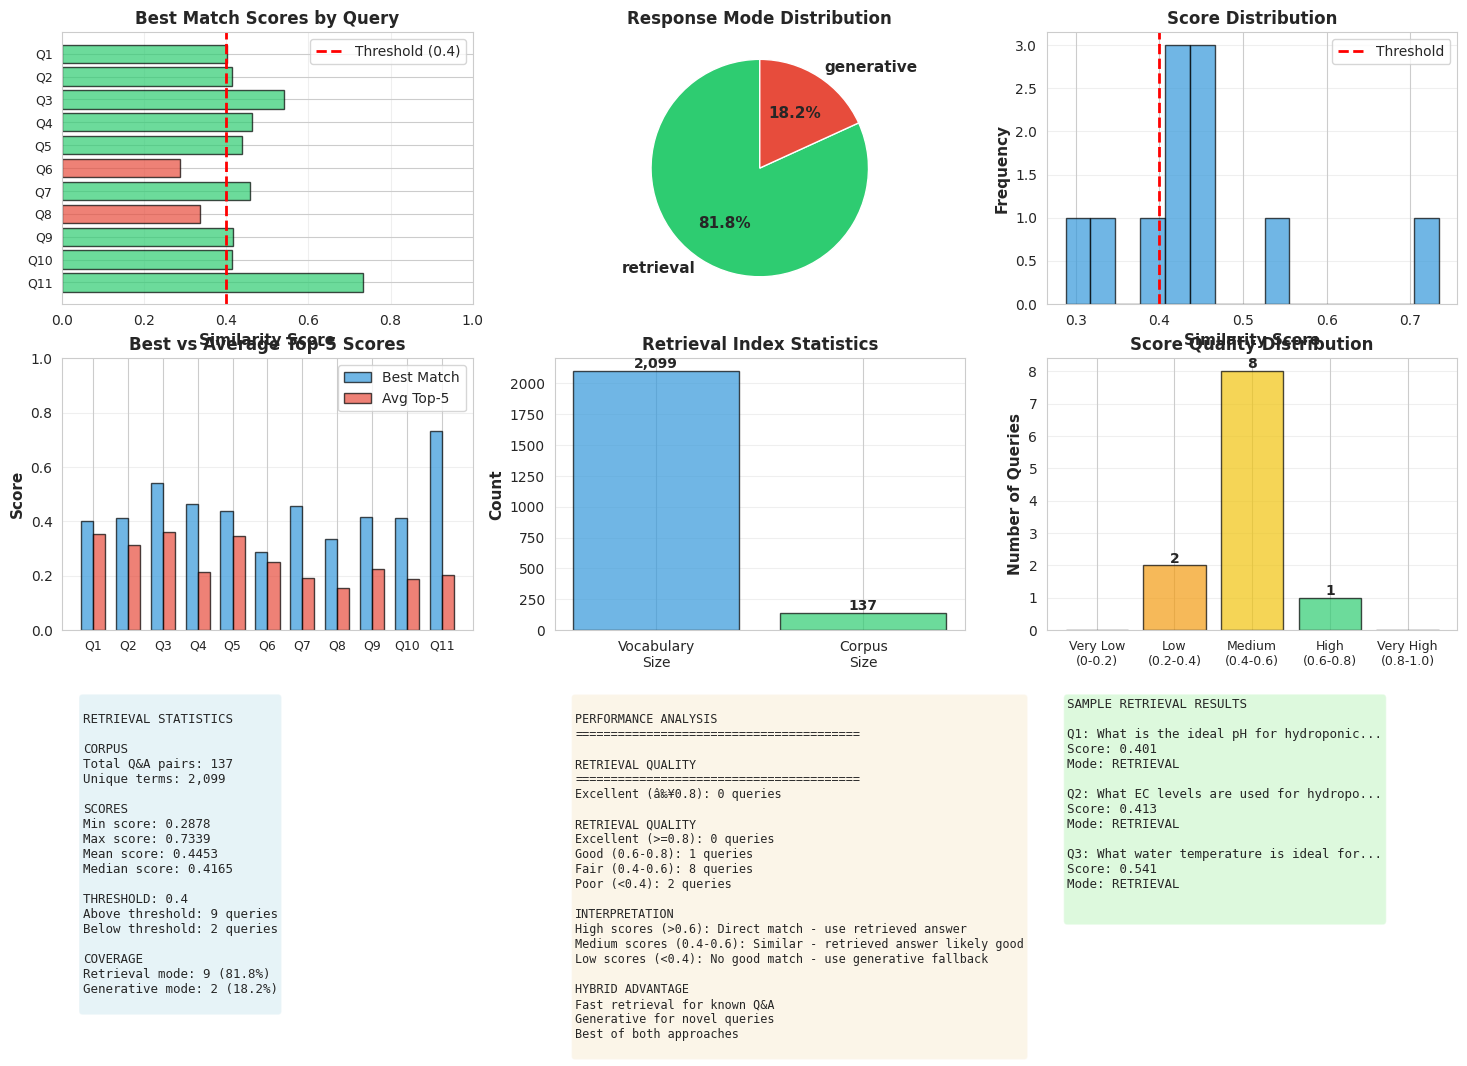


RETRIEVAL SYSTEM ANALYSIS
Total test queries: 11
Retrieval mode: 9 queries (81.8%)
Generative mode: 2 queries (18.2%)

Average best match score: 0.4453
Average top-5 score: 0.2547


In [26]:
# Analyze retrieval system performance with various test queries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Test queries covering different types and topics
test_queries = [
    # Direct matches (should have high scores)
    "What is the ideal pH for hydroponic lettuce?",
    "What EC levels are used for hydroponic lettuce?",
    "What water temperature is ideal for hydroponic lettuce?",

    # Similar but rephrased (moderate scores)
    "How do I maintain proper pH levels?",
    "What's the best EC range for growing lettuce?",
    "What nutrient temperature should I use?",

    # Topic-related but different wording (lower scores)
    "My plants are wilting, what's wrong?",
    "How do I prevent algae growth?",
    "Best practices for hydroponic farming?",

    # Edge cases
    "Tell me everything about hydroponics",
    "What equipment do I need?"
]

print("Testing retrieval system with various queries...")
retrieval_results = []

for query in test_queries:
    results = retrieve_answers(query, top_k=5)
    if results:
        best_score = results[0]['score']
        avg_score = np.mean([r['score'] for r in results])
        retrieval_results.append({
            'query': query[:50] + '...' if len(query) > 50 else query,
            'best_score': best_score,
            'avg_top5_score': avg_score,
            'mode': 'retrieval' if best_score >= 0.4 else 'generative'
        })

retrieval_df = pd.DataFrame(retrieval_results)

# Create comprehensive visualization
fig = plt.figure(figsize=(18, 12))

# 1. Best Match Scores for Each Query
ax1 = plt.subplot(3, 3, 1)
colors_mode = ['#2ecc71' if mode == 'retrieval' else '#e74c3c' for mode in retrieval_df['mode']]
bars = ax1.barh(range(len(retrieval_df)), retrieval_df['best_score'], color=colors_mode,
               edgecolor='black', alpha=0.7)
ax1.axvline(x=0.4, color='red', linestyle='--', linewidth=2, label='Threshold (0.4)')
ax1.set_yticks(range(len(retrieval_df)))
ax1.set_yticklabels([f"Q{i+1}" for i in range(len(retrieval_df))], fontsize=9)
ax1.set_xlabel('Similarity Score', fontsize=11, fontweight='bold')
ax1.set_title('Best Match Scores by Query', fontsize=12, fontweight='bold')
ax1.set_xlim([0, 1])
ax1.grid(axis='x', alpha=0.3)
ax1.legend()
ax1.invert_yaxis()

# 2. Mode Distribution (Retrieval vs Generative)
ax2 = plt.subplot(3, 3, 2)
mode_counts = retrieval_df['mode'].value_counts()
colors_pie = ['#2ecc71', '#e74c3c']
ax2.pie(mode_counts.values, labels=mode_counts.index, autopct='%1.1f%%',
        colors=colors_pie, startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
ax2.set_title('Response Mode Distribution', fontsize=12, fontweight='bold')

# 3. Score Distribution Histogram
ax3 = plt.subplot(3, 3, 3)
ax3.hist(retrieval_df['best_score'], bins=15, color='#3498db', edgecolor='black', alpha=0.7)
ax3.axvline(x=0.4, color='red', linestyle='--', linewidth=2, label='Threshold')
ax3.set_xlabel('Similarity Score', fontsize=11, fontweight='bold')
ax3.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax3.set_title('Score Distribution', fontsize=12, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)
ax3.legend()

# 4. Best vs Average Top-5 Scores
ax4 = plt.subplot(3, 3, 4)
x_pos = np.arange(len(retrieval_df))
width = 0.35
bars1 = ax4.bar(x_pos - width/2, retrieval_df['best_score'], width,
               label='Best Match', color='#3498db', edgecolor='black', alpha=0.7)
bars2 = ax4.bar(x_pos + width/2, retrieval_df['avg_top5_score'], width,
               label='Avg Top-5', color='#e74c3c', edgecolor='black', alpha=0.7)
ax4.set_ylabel('Score', fontsize=11, fontweight='bold')
ax4.set_title('Best vs Average Top-5 Scores', fontsize=12, fontweight='bold')
ax4.set_xticks(x_pos)
ax4.set_xticklabels([f'Q{i+1}' for i in range(len(retrieval_df))], fontsize=9)
ax4.set_ylim([0, 1])
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

# 5. TF-IDF Vocabulary Size
ax5 = plt.subplot(3, 3, 5)
vocab_size = len(tfidf_vectorizer.vocabulary_)
corpus_size = len(retrieval_questions)
ax5.bar(['Vocabulary\nSize', 'Corpus\nSize'], [vocab_size, corpus_size],
       color=['#3498db', '#2ecc71'], edgecolor='black', alpha=0.7)
ax5.set_ylabel('Count', fontsize=11, fontweight='bold')
ax5.set_title('Retrieval Index Statistics', fontsize=12, fontweight='bold')
ax5.grid(axis='y', alpha=0.3)
for i, val in enumerate([vocab_size, corpus_size]):
    ax5.text(i, val, f'{val:,}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# 6. Score Categories
ax6 = plt.subplot(3, 3, 6)
score_categories = pd.cut(retrieval_df['best_score'],
                         bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0],
                         labels=['Very Low\n(0-0.2)', 'Low\n(0.2-0.4)',
                                'Medium\n(0.4-0.6)', 'High\n(0.6-0.8)', 'Very High\n(0.8-1.0)'])
category_counts = score_categories.value_counts().sort_index()
colors_cat = ['#e74c3c', '#f39c12', '#f1c40f', '#2ecc71', '#27ae60']
bars = ax6.bar(range(len(category_counts)), category_counts.values,
              color=colors_cat, edgecolor='black', alpha=0.7)
ax6.set_xticks(range(len(category_counts)))
ax6.set_xticklabels(category_counts.index, fontsize=9)
ax6.set_ylabel('Number of Queries', fontsize=11, fontweight='bold')
ax6.set_title('Score Quality Distribution', fontsize=12, fontweight='bold')
ax6.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    if height > 0:
        ax6.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom', fontweight='bold')

# 7. Statistics Summary (Text)
ax7 = plt.subplot(3, 3, 7)
ax7.axis('off')
stats_text = f"""
RETRIEVAL STATISTICS

CORPUS
Total Q&A pairs: {len(retrieval_questions):,}
Unique terms: {vocab_size:,}

SCORES
Min score: {retrieval_df['best_score'].min():.4f}
Max score: {retrieval_df['best_score'].max():.4f}
Mean score: {retrieval_df['best_score'].mean():.4f}
Median score: {retrieval_df['best_score'].median():.4f}

THRESHOLD: 0.4
Above threshold: {(retrieval_df['best_score'] >= 0.4).sum()} queries
Below threshold: {(retrieval_df['best_score'] < 0.4).sum()} queries

COVERAGE
Retrieval mode: {(retrieval_df['mode'] == 'retrieval').sum()} ({(retrieval_df['mode'] == 'retrieval').sum()/len(retrieval_df)*100:.1f}%)
Generative mode: {(retrieval_df['mode'] == 'generative').sum()} ({(retrieval_df['mode'] == 'generative').sum()/len(retrieval_df)*100:.1f}%)
"""
ax7.text(0.05, 0.95, stats_text, fontsize=9, verticalalignment='top',
        fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

# 8. Performance Breakdown
ax8 = plt.subplot(3, 3, 8)
ax8.axis('off')
perf_text = f"""
PERFORMANCE ANALYSIS
{'='*40}

RETRIEVAL QUALITY
{'='*40}
Excellent (â‰¥0.8): {(retrieval_df['best_score'] >= 0.8).sum()} queries

RETRIEVAL QUALITY
Excellent (>=0.8): {(retrieval_df['best_score'] >= 0.8).sum()} queries
Good (0.6-0.8): {((retrieval_df['best_score'] >= 0.6) & (retrieval_df['best_score'] < 0.8)).sum()} queries
Fair (0.4-0.6): {((retrieval_df['best_score'] >= 0.4) & (retrieval_df['best_score'] < 0.6)).sum()} queries
Poor (<0.4): {(retrieval_df['best_score'] < 0.4).sum()} queries

INTERPRETATION
High scores (>0.6): Direct match - use retrieved answer
Medium scores (0.4-0.6): Similar - retrieved answer likely good
Low scores (<0.4): No good match - use generative fallback

HYBRID ADVANTAGE
Fast retrieval for known Q&A
Generative for novel queries
Best of both approaches
"""
ax8.text(0.05, 0.95, perf_text, fontsize=8.5, verticalalignment='top',
        fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

# 9. Sample Query Results (Text)
ax9 = plt.subplot(3, 3, 9)
ax9.axis('off')
sample_text = "SAMPLE RETRIEVAL RESULTS\n\n"
for i in range(min(3, len(retrieval_df))):
    row = retrieval_df.iloc[i]
    sample_text += f"Q{i+1}: {row['query'][:35]}...\n"
    sample_text += f"Score: {row['best_score']:.3f}\n"
    sample_text += f"Mode: {row['mode'].upper()}\n\n"
ax9.text(0.05, 0.95, sample_text, fontsize=9, verticalalignment='top',
        fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3))

sample_text = "SAMPLE RETRIEVAL RESULTS\n\n"
plt.savefig('chatbot_retrieval_performance.png', dpi=300, bbox_inches='tight')
print("Saved: chatbot_retrieval_performance.png")
plt.show()

# Print detailed results
print("\nRETRIEVAL SYSTEM ANALYSIS")
print(f"Total test queries: {len(retrieval_df)}")
print(f"Retrieval mode: {(retrieval_df['mode'] == 'retrieval').sum()} queries ({(retrieval_df['mode'] == 'retrieval').sum()/len(retrieval_df)*100:.1f}%)")
print(f"Generative mode: {(retrieval_df['mode'] == 'generative').sum()} queries ({(retrieval_df['mode'] == 'generative').sum()/len(retrieval_df)*100:.1f}%)")
print(f"\nAverage best match score: {retrieval_df['best_score'].mean():.4f}")
print(f"Average top-5 score: {retrieval_df['avg_top5_score'].mean():.4f}")